<a href="https://colab.research.google.com/github/ZPavlo/ML_projects/blob/master/CIFAR100_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/datasets/'

import torch
import torchvision
import torchvision.transforms as transforms

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt

BATCH_SIZE = 64
WORKERS = 64 * 2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            normalize,
        ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

trainset = torchvision.datasets.CIFAR100(root=root_path, train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=WORKERS)

testset = torchvision.datasets.CIFAR100(root=root_path, train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=WORKERS)



Files already downloaded and verified
Files already downloaded and verified


tensor(2.6400) tensor(-2.1179)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


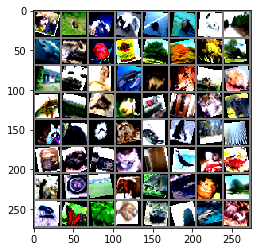

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.max(), images.min())
imshow(torchvision.utils.make_grid(images))

In [0]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

LR = 0.05

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=100, bias=True)
)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 50, 75, 100], gamma=0.2)

In [5]:
import os

checkpoint_path = os.path.join("gdrive/My Drive/saves/mobilenet")  + '{epoch}-{type}.pth'
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

mobilenet.cuda()
print("CUDA")

CUDA


In [6]:
def train(epoch, net):

    net.train()
    global_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):

        images.requires_grad = True
        # labels.requires_grad = True

        labels = labels.cuda()
        images = images.cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        global_loss += float(loss)

        if (i + 1) % 100 == 0:
          print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
              loss.item(),
              optimizer.param_groups[0]['lr'],
              epoch=epoch,
              total_samples=len(trainset),
              trained_samples=i * BATCH_SIZE
          ))

    return global_loss / i

def eval_training(epoch, net):
    net.eval()

    test_loss = 0.0 
    correct = 0.0

    for i, (images, labels) in enumerate(testloader):
        images.requires_grad = True
        # labels.requires_grad = True

        labels = labels.cuda()
        images = images.cuda()

        outputs = net(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum()

    print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
        test_loss / len(testset),
        correct.float() / len(testset)
    ))
    print()

    return float(correct) / len(testset)

EPOCHS=200
best_acc = 0.0
acc_list = []
loss_list = []
# torch.save(mobilenet.state_dict(), checkpoint_path.format(epoch=epoch, type='best'))
# mobilenet.load_state_dict(torch.load(checkpoint_path.format(epoch=18, type='best')))
for epoch in range(1, EPOCHS):

    train_loss = train(epoch, mobilenet)
    acc = eval_training(epoch, mobilenet)

    train_scheduler.step(epoch)
    loss_list.append(train_loss)
    acc_list.append(acc)

    #start to save best performance model after learning rate decay to 0.01 
    if best_acc < acc:
        torch.save(mobilenet.state_dict(), checkpoint_path.format(epoch=epoch, type='best'))
        best_acc = acc
        continue

    if (epoch + 1) % 10 == 0:
        torch.save(mobilenet.state_dict(), checkpoint_path.format(epoch=epoch, type='regular'))


Training Epoch: 1 [6336/50000]	Loss: 4.8297	LR: 0.050000
Training Epoch: 1 [12736/50000]	Loss: 4.9095	LR: 0.050000
Training Epoch: 1 [19136/50000]	Loss: 4.6175	LR: 0.050000
Training Epoch: 1 [25536/50000]	Loss: 4.7994	LR: 0.050000
Training Epoch: 1 [31936/50000]	Loss: 4.6695	LR: 0.050000
Training Epoch: 1 [38336/50000]	Loss: 4.6819	LR: 0.050000
Training Epoch: 1 [44736/50000]	Loss: 4.4855	LR: 0.050000
Test set: Average loss: 0.0846, Accuracy: 0.0105

Training Epoch: 2 [6336/50000]	Loss: 4.6090	LR: 0.050000
Training Epoch: 2 [12736/50000]	Loss: 4.5671	LR: 0.050000
Training Epoch: 2 [19136/50000]	Loss: 4.6620	LR: 0.050000
Training Epoch: 2 [25536/50000]	Loss: 4.5385	LR: 0.050000
Training Epoch: 2 [31936/50000]	Loss: 4.6307	LR: 0.050000
Training Epoch: 2 [38336/50000]	Loss: 4.6970	LR: 0.050000
Training Epoch: 2 [44736/50000]	Loss: 4.3888	LR: 0.050000
Test set: Average loss: 0.0687, Accuracy: 0.0297

Training Epoch: 3 [6336/50000]	Loss: 4.4381	LR: 0.050000
Training Epoch: 3 [12736/50000]	L

KeyboardInterrupt: ignored

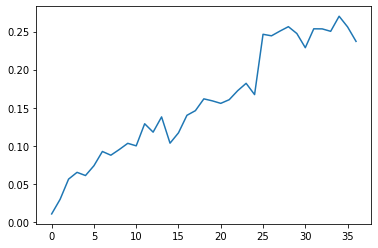

In [8]:
plt.plot(list(range(len(acc_list))), acc_list)
plt.show()

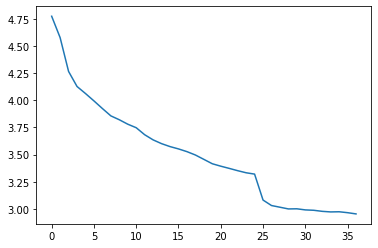

In [9]:
plt.plot(list(range(len(loss_list))), loss_list)
plt.show()